# Import Libraries

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 31.6 MB/s 
     |████████████████████████████████| 7.6 MB 22.7 MB/s 
     |████████████████████████████████| 163 kB 39.3 MB/s 


In [2]:
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModelForMaskedLM, BertTokenizerFast
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Define the Templates for Prior Estimation

In [3]:
# define the templates to fill

prior_templates = [
    '[MASK] is a [MASK].',
    '[MASK] is an [MASK].',
    '[MASK] works as a [MASK].',
    '[MASK] works as an [MASK].'
]

# define the filler tokens (pronouns)

tokens = ['he', 'she']

# The Publicly Released roberta-base

In [4]:
# load the model

model = AutoModelForMaskedLM.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# prepare the unmasker
unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# use the unmasker to get the result
results = unmasker(prior_templates, targets=tokens)

In [6]:
# initialize the empty dataframe to save results
prior = pd.DataFrame(columns=['pronoun', 'score', 'occupation', 'template',
                              'sentence', 'model', 'seed', 'checkpoint'])

# loop over templates and their results
for result, template in zip(results, prior_templates):

    # just take the first masked token
    for r in result[0][:2]:

        # fill in the data
        new_row = dict()
        new_row['pronoun'] = r['token_str']
        new_row['score'] = r['score']
        new_row['occupation'] = '[MASK]'
        new_row['template'] = template
        new_row['sentence'] = r['sequence']
        new_row['model'] = 'bert-base-uncased'
        new_row['seed'] = -1 # default model
        # no checkpoint

        # append the data
        prior.loc[len(prior.index)] = new_row

# preview the results
display(prior)

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
0,he,0.554626,[MASK],[MASK] is a [MASK].,[CLS] he is a [MASK]. [SEP],bert-base-uncased,-1,NaN
1,she,0.161651,[MASK],[MASK] is a [MASK].,[CLS] she is a [MASK]. [SEP],bert-base-uncased,-1,NaN
2,he,0.601791,[MASK],[MASK] is an [MASK].,[CLS] he is an [MASK]. [SEP],bert-base-uncased,-1,NaN
3,she,0.198693,[MASK],[MASK] is an [MASK].,[CLS] she is an [MASK]. [SEP],bert-base-uncased,-1,NaN
4,he,0.735957,[MASK],[MASK] works as a [MASK].,[CLS] he works as a [MASK]. [SEP],bert-base-uncased,-1,NaN
5,she,0.211022,[MASK],[MASK] works as a [MASK].,[CLS] she works as a [MASK]. [SEP],bert-base-uncased,-1,NaN
6,he,0.695264,[MASK],[MASK] works as an [MASK].,[CLS] he works as an [MASK]. [SEP],bert-base-uncased,-1,NaN
7,she,0.252540,[MASK],[MASK] works as an [MASK].,[CLS] she works as an [MASK]. [SEP],bert-base-uncased,-1,NaN


# Custom RoBERTa Checkpoints

In [7]:
# save the checkpoint numbers, from 0 to 2,000,000 for bert
checkpoints = []

# read in numbers
with open('/content/drive/MyDrive/bert-checkpoints/steps.txt', 'r') as f:
    for line in f:
        checkpoints.append(int(line))

# check if numbers are correct
print(checkpoints)

[0, 20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, 1100000, 1200000, 1300000, 1400000, 1500000, 1600000, 1700000, 1800000, 1900000, 2000000]


In [8]:
# loop over 5 seeds
for seed in [0, 1, 2, 3, 4]:

    # loop over checkpoints, 29 for each seed
    for checkpoint in tqdm(checkpoints):
        
        # read model and prepare unmasker
        model = AutoModelForMaskedLM.from_pretrained(f'/content/drive/MyDrive/bert-checkpoints/pytorch_checkpoints/seed_{seed}/step_{checkpoint}')
        tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

        unmasker = pipeline('fill-mask', model=model, tokenizer=tokenizer)

        # get results
        results = unmasker(prior_templates, targets=tokens)

        # loop over templates and their results
        for result, template in zip(results, prior_templates):

            # just take the first masked token
            for r in result[0][:2]:

                # fill in the data
                new_row = dict()
                new_row['pronoun'] = r['token_str']
                new_row['score'] = r['score']
                new_row['occupation'] = '[MASK]'
                new_row['template'] = template
                new_row['sentence'] = r['sequence']
                new_row['model'] = 'bert-base-uncased'
                new_row['seed'] = seed 
                new_row['checkpoint'] = checkpoint

                # append the data
                prior.loc[len(prior.index)] = new_row

  0%|          | 0/29 [00:00<?, ?it/s]Some weights of the model checkpoint at /content/drive/MyDrive/bert-checkpoints/pytorch_checkpoints/seed_0/step_0 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  3%|▎         | 1/29 [00:07<03:24,  7.29s/it]Some weights of the model checkpoint at /content/drive/MyDrive/bert-checkpoints/pytorch_checkpoints/seed_0/step_20000 were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']

# Check and Save results

In [9]:
# check head
prior.head()

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
0,he,0.554626,[MASK],[MASK] is a [MASK].,[CLS] he is a [MASK]. [SEP],bert-base-uncased,-1,NaN
1,she,0.161651,[MASK],[MASK] is a [MASK].,[CLS] she is a [MASK]. [SEP],bert-base-uncased,-1,NaN
2,he,0.601791,[MASK],[MASK] is an [MASK].,[CLS] he is an [MASK]. [SEP],bert-base-uncased,-1,NaN
3,she,0.198693,[MASK],[MASK] is an [MASK].,[CLS] she is an [MASK]. [SEP],bert-base-uncased,-1,NaN
4,he,0.735957,[MASK],[MASK] works as a [MASK].,[CLS] he works as a [MASK]. [SEP],bert-base-uncased,-1,NaN


In [10]:
# check tail
prior.tail()

,pronoun,score,occupation,template,sentence,model,seed,checkpoint
1163,she,0.171592,[MASK],[MASK] is an [MASK].,[CLS] she is an [MASK]. [SEP],bert-base-uncased,4,2000000.0
1164,he,0.460334,[MASK],[MASK] works as a [MASK].,[CLS] he works as a [MASK]. [SEP],bert-base-uncased,4,2000000.0
1165,she,0.424608,[MASK],[MASK] works as a [MASK].,[CLS] she works as a [MASK]. [SEP],bert-base-uncased,4,2000000.0
1166,she,0.477618,[MASK],[MASK] works as an [MASK].,[CLS] she works as an [MASK]. [SEP],bert-base-uncased,4,2000000.0
1167,he,0.395122,[MASK],[MASK] works as an [MASK].,[CLS] he works as an [MASK]. [SEP],bert-base-uncased,4,2000000.0


In [11]:
# check length
# 8 for each checkpoint, total 1+29*5=146 model checkpoints, should get 1168

len(prior.index)

1168

In [12]:
# save after checking correctness

# file name, save in the data subfolder
out_file = '/content/drive/MyDrive/checkpoint-bias/data/bert-prior.pkl'

# save file
prior.to_pickle(out_file)

# Generate Plots

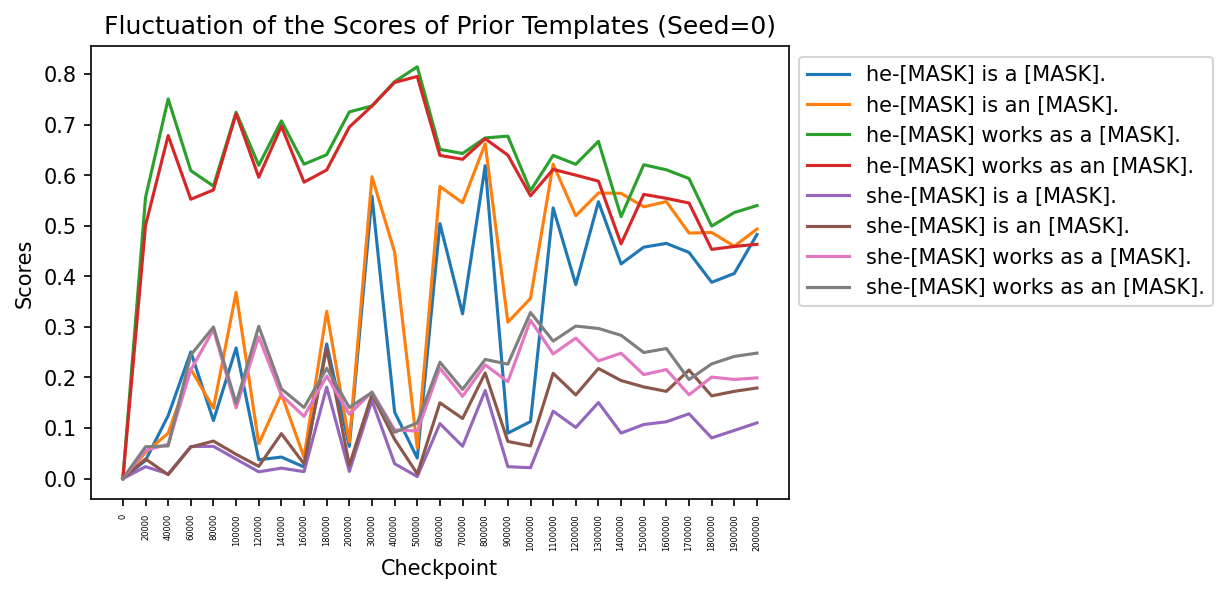

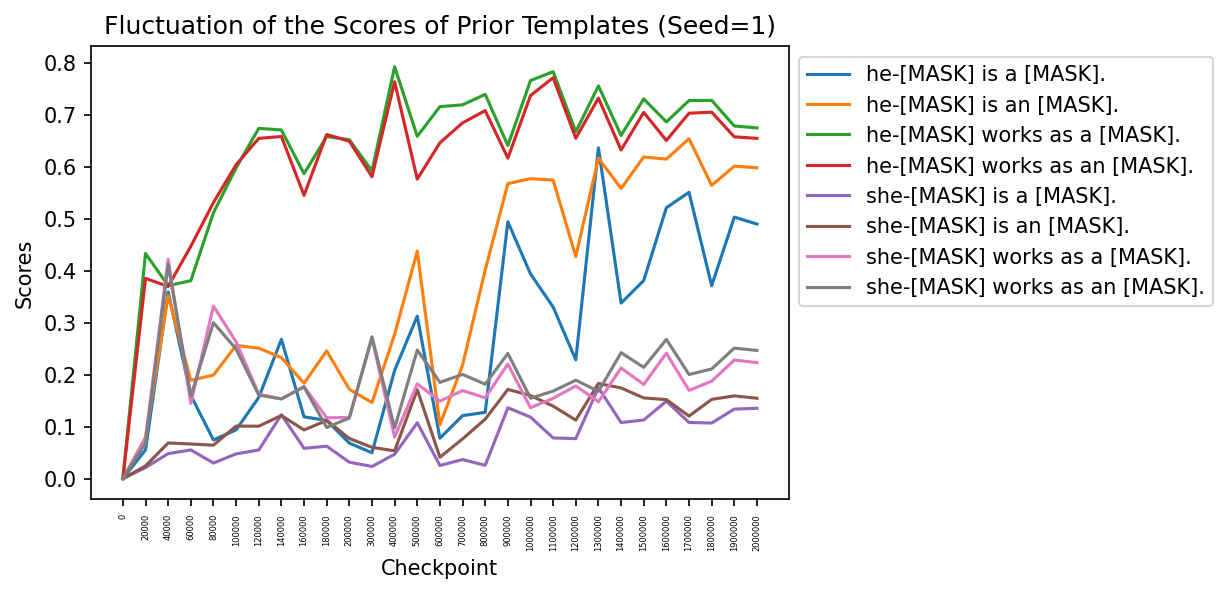

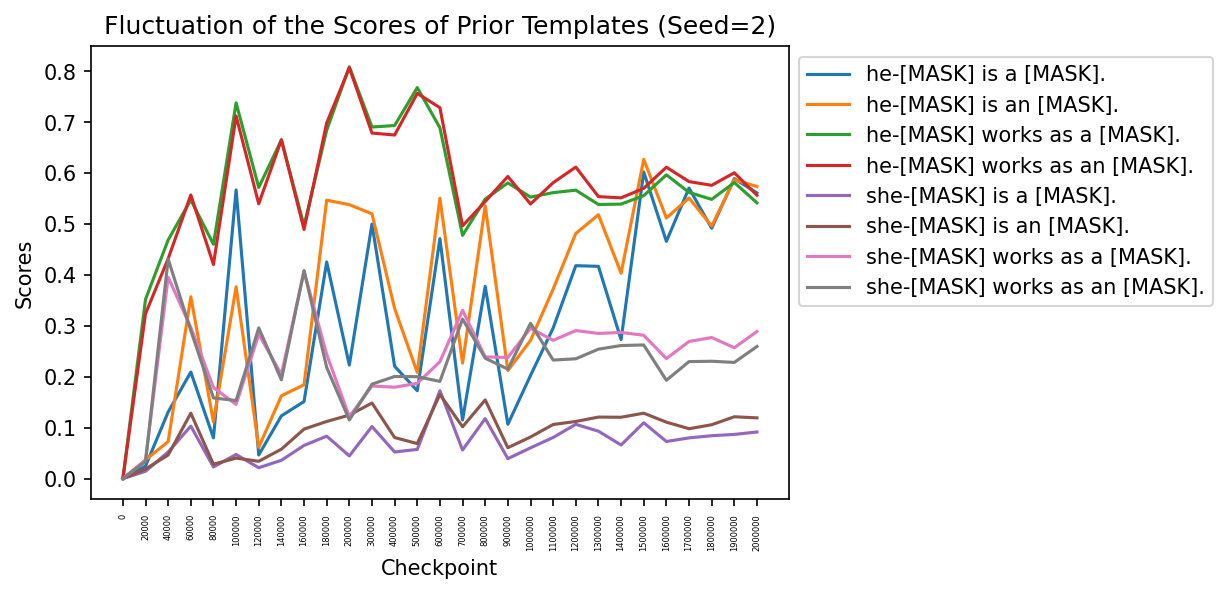

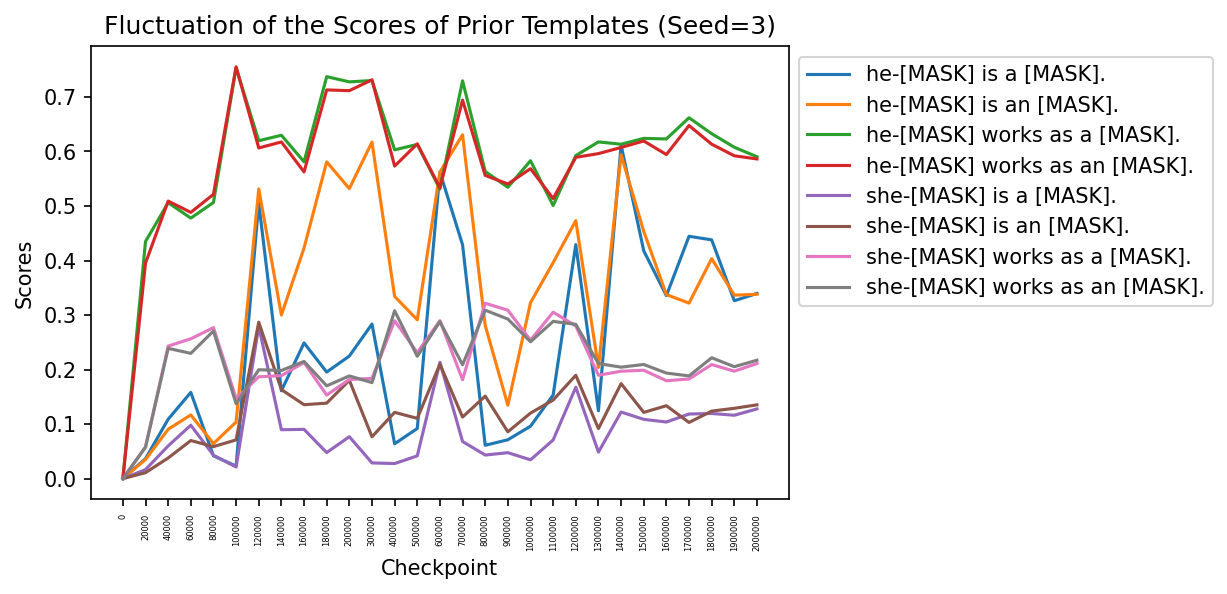

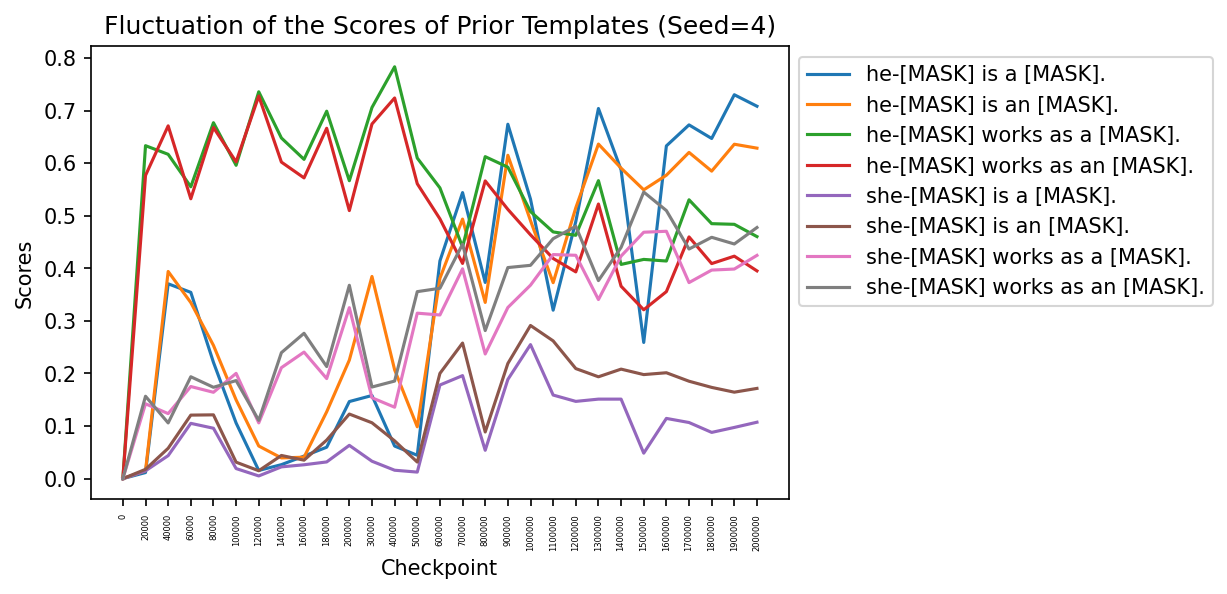

In [13]:
# plot the 8 lines of probability fluctuations of the custom model
# for each seed, 5 plots in total

for seed in [0, 1, 2, 3, 4]:

    # initialize plot
    fig, ax = plt.subplots(dpi=150)

    # loop over 2 tokens (pronouns)
    for token in tokens:

        # loop over 4 templates
        for template in prior_templates:

            # get the sequence of probabilities, guaranteed to be in correct order
            scores = prior[
                (prior['pronoun'] == token) & # 1 of the 2 pronouns
                (prior['template'] == template) & # 1 of the 4 templates
                (prior['seed'] == seed) # the custom bert
            ]['score']

            ax.plot(range(len(scores)), scores, label = f'{token}-{template}')

    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Scores')

    ax.set_xticks(range(len(checkpoints)))
    ax.set_xticklabels(checkpoints, rotation = 90, fontsize=4)

    ax.set_title(f'Fluctuation of the Scores of Prior Templates (Seed={seed})')
    ax.legend(bbox_to_anchor=[1, 1], loc = 'upper left')

    plt.show()

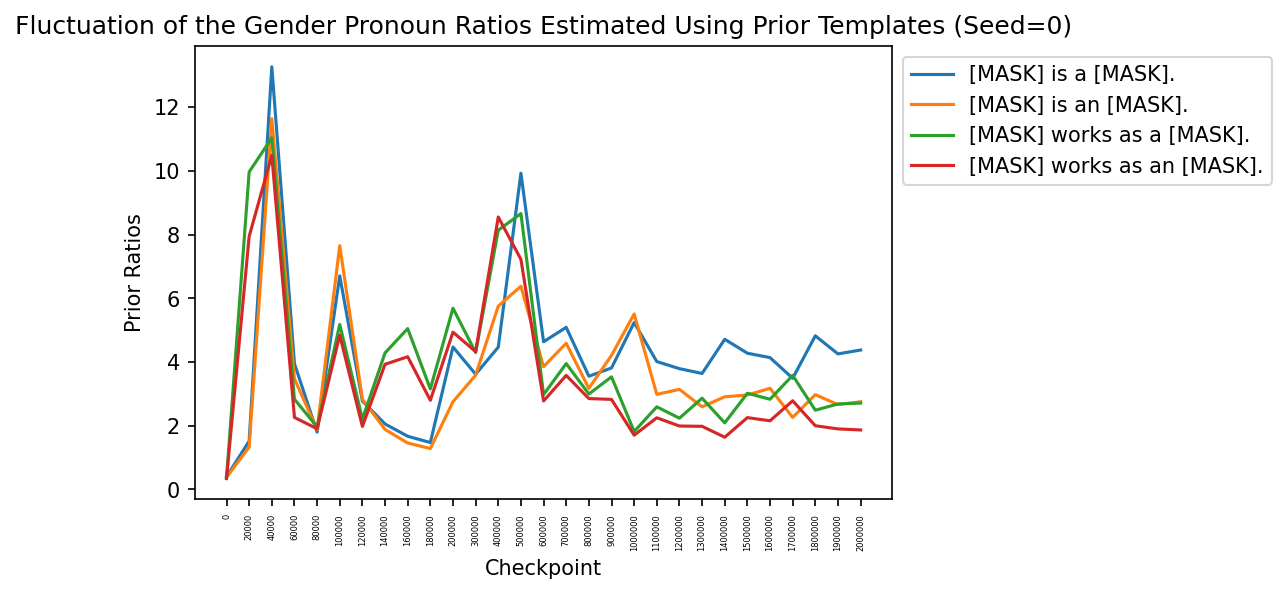

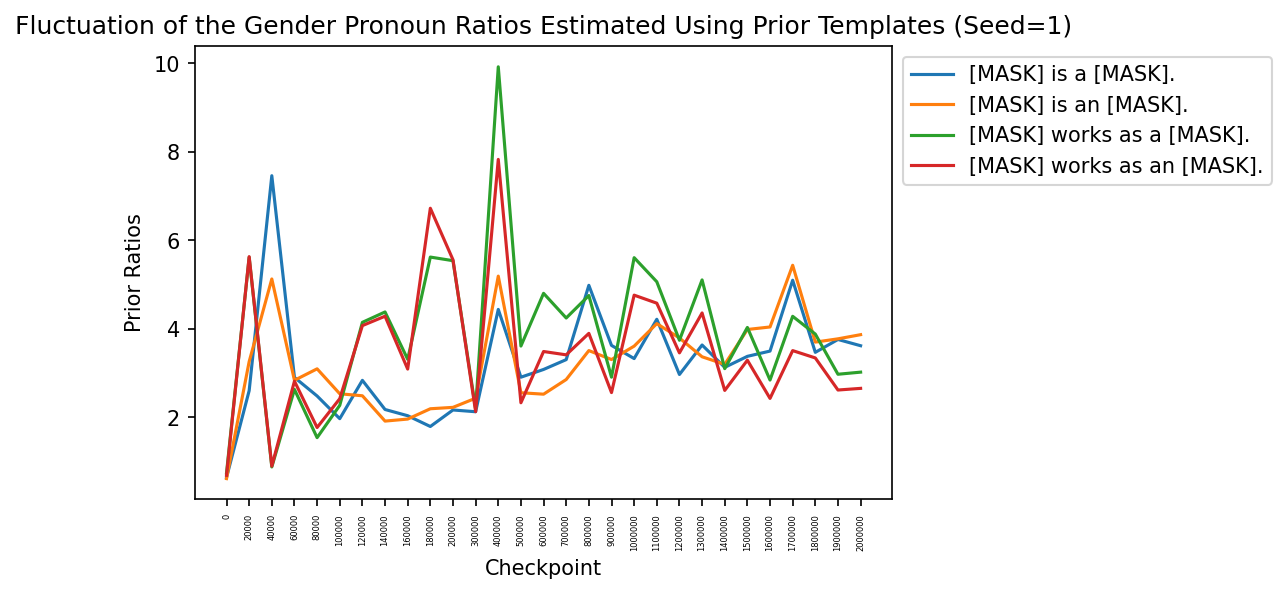

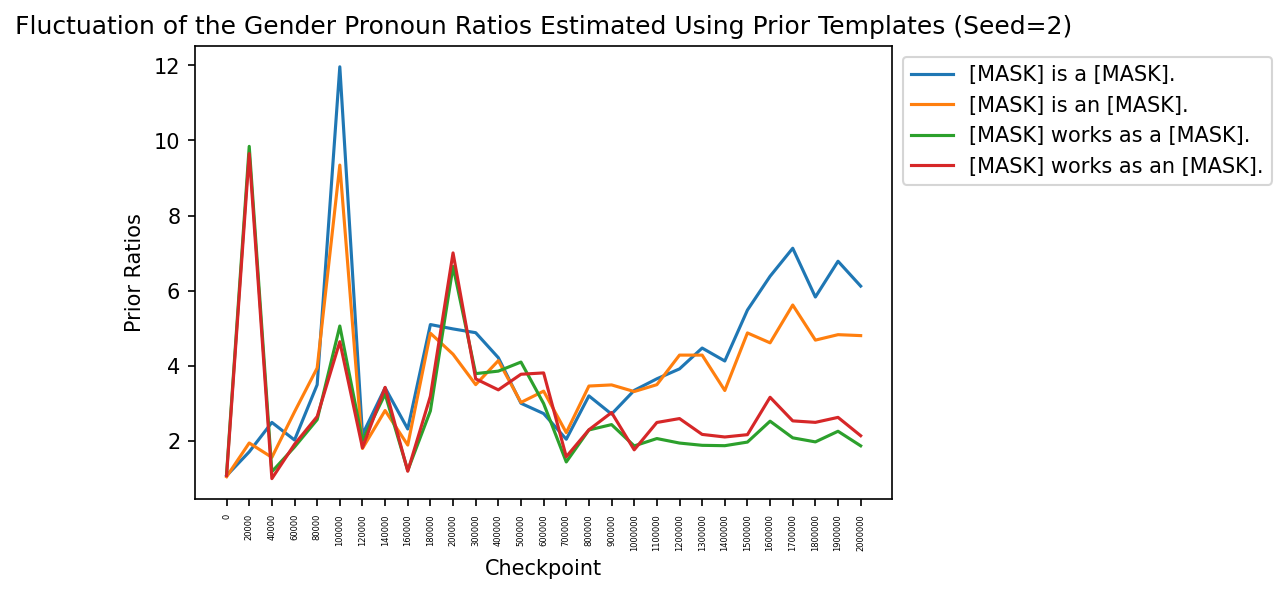

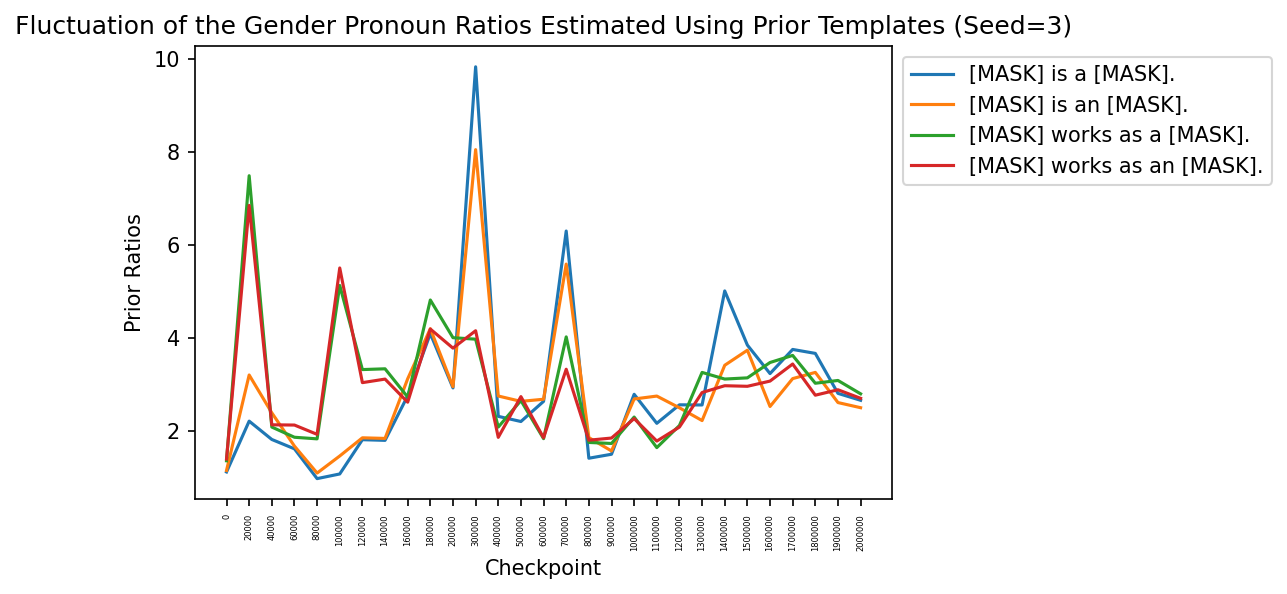

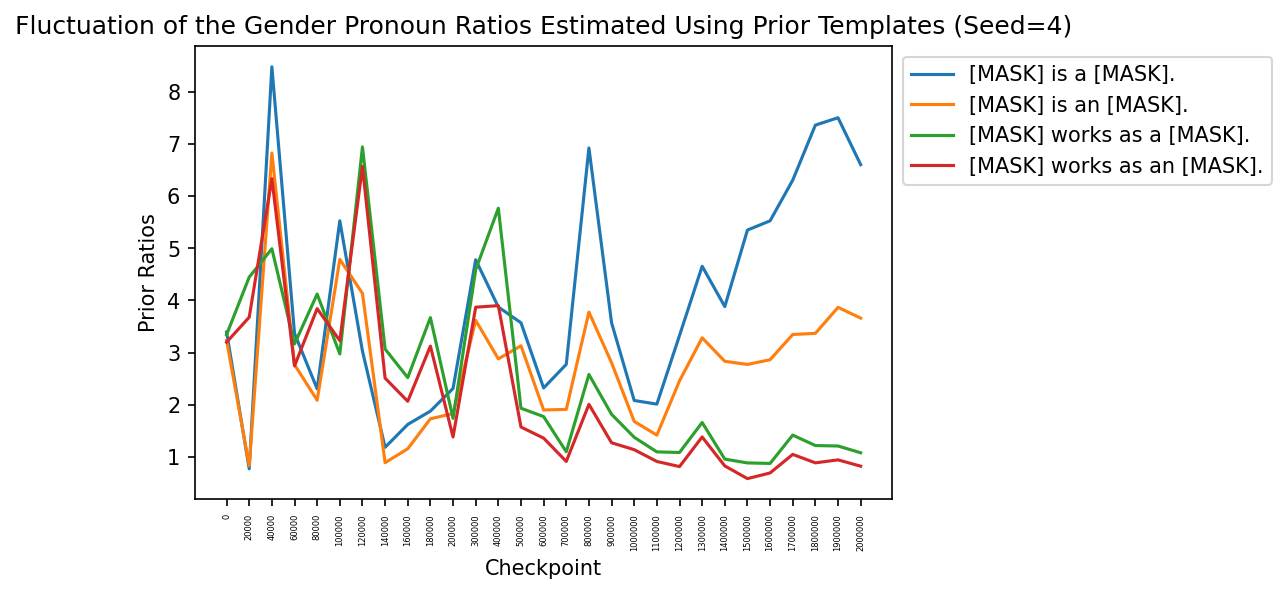

In [15]:
# plot the 4 lines of ratio fluctuations of the custom model
# for each seed, 5 plots in total

for seed in [0, 1, 2, 3, 4]:

    # initialize plot
    fig, ax = plt.subplots(dpi=150)

    # loop over 4 templates
    for template in prior_templates:

        # get the sequence of probabilities for he
        he_scores = prior[
            (prior['pronoun'] == 'he') & # he
            (prior['template'] == template) & # 1 of the 4 templates
            (prior['seed'] == seed) # the custom bert
        ]['score']

        # get the sequence of probabilities for she
        she_scores = prior[
            (prior['pronoun'] == 'she') & # she
            (prior['template'] == template) & # 1 of the 4 templates
            (prior['seed'] == seed) # the custom bert
        ]['score']

        # calculate ratios of he/she
        ratios = np.array(he_scores) / np.array(she_scores)

        ax.plot(range(len(scores)), ratios, label = f'{template}')

    ax.set_xlabel('Checkpoint')
    ax.set_ylabel('Prior Ratios')

    ax.set_xticks(range(len(checkpoints)))
    ax.set_xticklabels(checkpoints, rotation = 90, fontsize=4)

    ax.set_title(f'Fluctuation of the Gender Pronoun Ratios Estimated Using Prior Templates (Seed={seed})')
    ax.legend(bbox_to_anchor=[1, 1], loc='upper left')

    plt.show()